# AP location prediction (2F and 3F floors only)
**Following the methods explored in the `ap_coordinates_prediction_review.ipynb`, focused on floors 2F and 3F**

In [2]:
import time 
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

import optuna
from xgboost import XGBClassifier, XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

## Load data 

In [3]:
import os

# Set the path to the main root of the project
# This is the folder that contains the 'ap_data' directory
project_root = '/home/sionna/Documents/GitTest2/AP-Sionna-Testing' 

os.chdir(project_root)

# Print the current working directory to confirm it's correct
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/sionna/Documents/GitTest2/AP-Sionna-Testing


In [45]:
# Use a path relative to your main project folder
path = 'ap_data/ap_data_all_floors.csv'

data = pd.read_csv(path)
print(f"Original data shape: {data.shape}")

# Filter data to only include floors 2F and 3F
data = data[data['ap_name'].str.contains('2F|3F', regex=True)]
print(f"Filtered data shape (2F and 3F only): {data.shape}")

Original data shape: (70452, 70)
Filtered data shape (2F and 3F only): (33840, 70)


In [5]:
# Set max valid RSSI to 200
data = data.dropna(subset=[data.columns[-1]])
data.replace({np.nan: 200}, inplace=True)
data.iloc[:, 4:-4] = data.iloc[:, 4:-4].clip(upper=200)

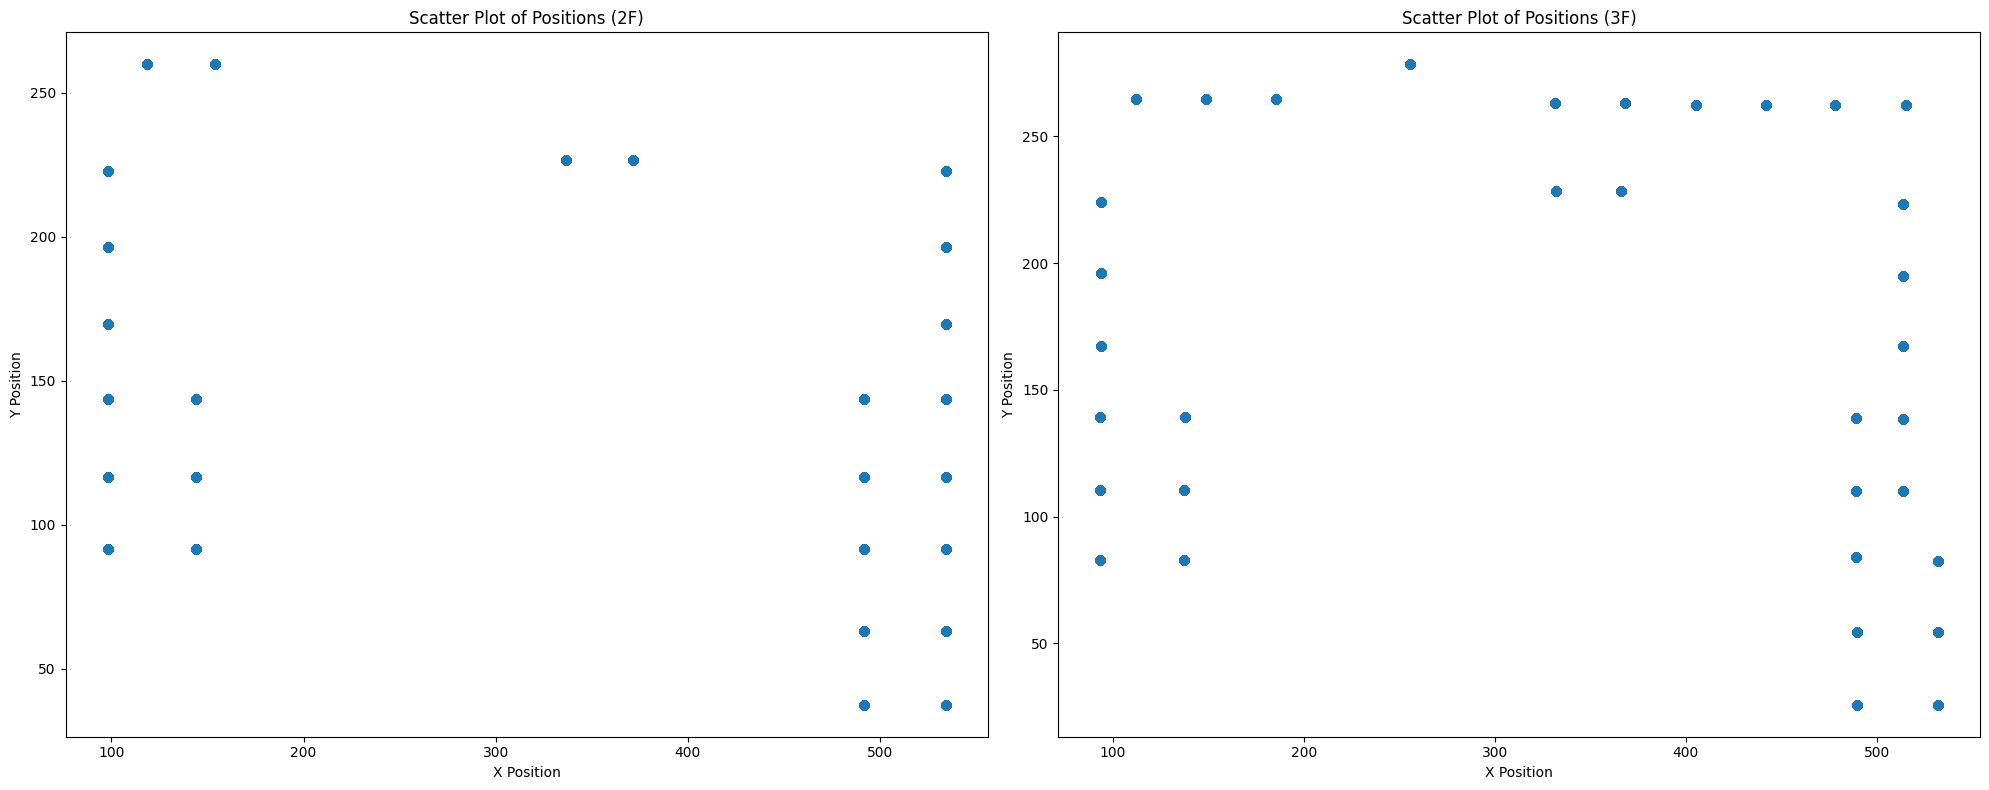

In [46]:
unique_floors = data['ap_name'].str.extract('(\d+F)')[0].unique()
num_floors = len(unique_floors)
fig, axes = plt.subplots(1, num_floors, figsize=(20 * num_floors // 2, 8))

for i, floor in enumerate(sorted(unique_floors)):
    floor_data = data[data['ap_name'].str.contains(floor)]
    axes[i].scatter(floor_data.iloc[:, -3], floor_data.iloc[:, -2])
    axes[i].set_xlabel('X Position')
    axes[i].set_ylabel('Y Position')
    axes[i].set_title(f'Scatter Plot of Positions ({floor})')

plt.tight_layout()
plt.show()

There isn't enough data to cover all the access points (APs), so some floors appear empty due to the lack of data for all APs on those floors

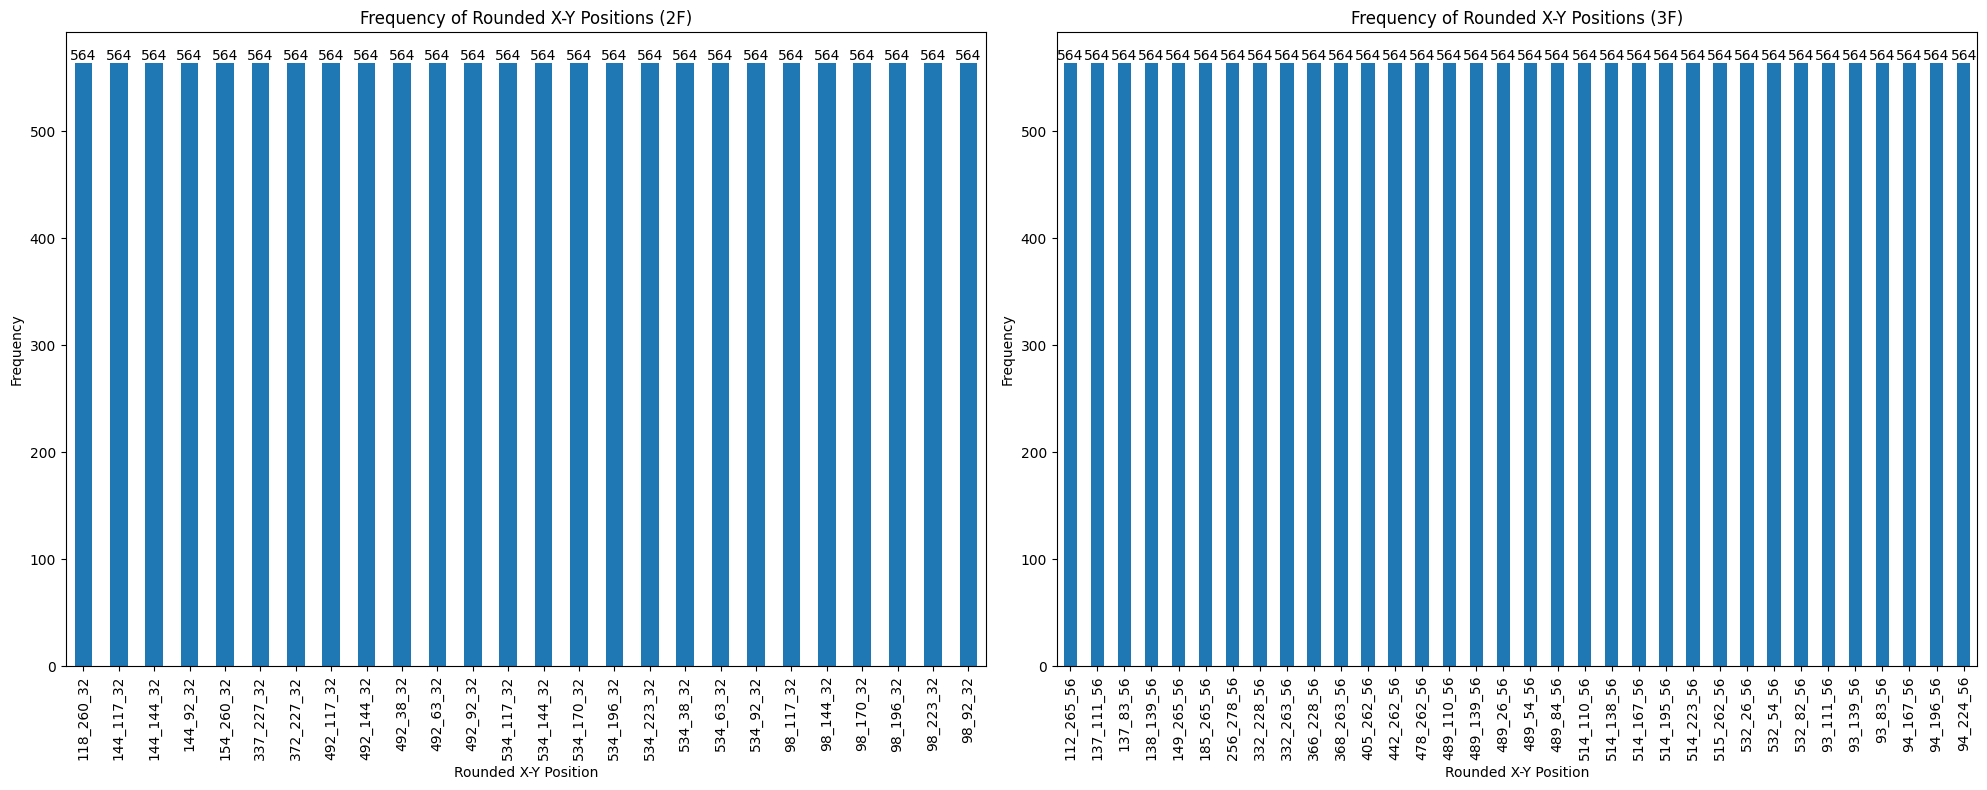

In [47]:
data['rounded_position'] = data.apply(lambda row: f"{int(round(row.iloc[-3]))}_{int(round(row.iloc[-2]))}_{int(round(row.iloc[-1]))}", axis=1)

unique_floors = data['ap_name'].str.extract('(\d+F)')[0].unique()
num_floors = len(unique_floors)
fig, axes = plt.subplots(1, num_floors, figsize=(20 * num_floors // 2, 8))

for i, floor in enumerate(sorted(unique_floors)):
    floor_data = data[data['ap_name'].str.contains(floor)]
    position_counts = floor_data['rounded_position'].value_counts().sort_index()
    
    position_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Frequency of Rounded X-Y Positions ({floor})')
    axes[i].set_xlabel('Rounded X-Y Position')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=90)
    
    for j, v in enumerate(position_counts):
        axes[i].text(j, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Data Distribution

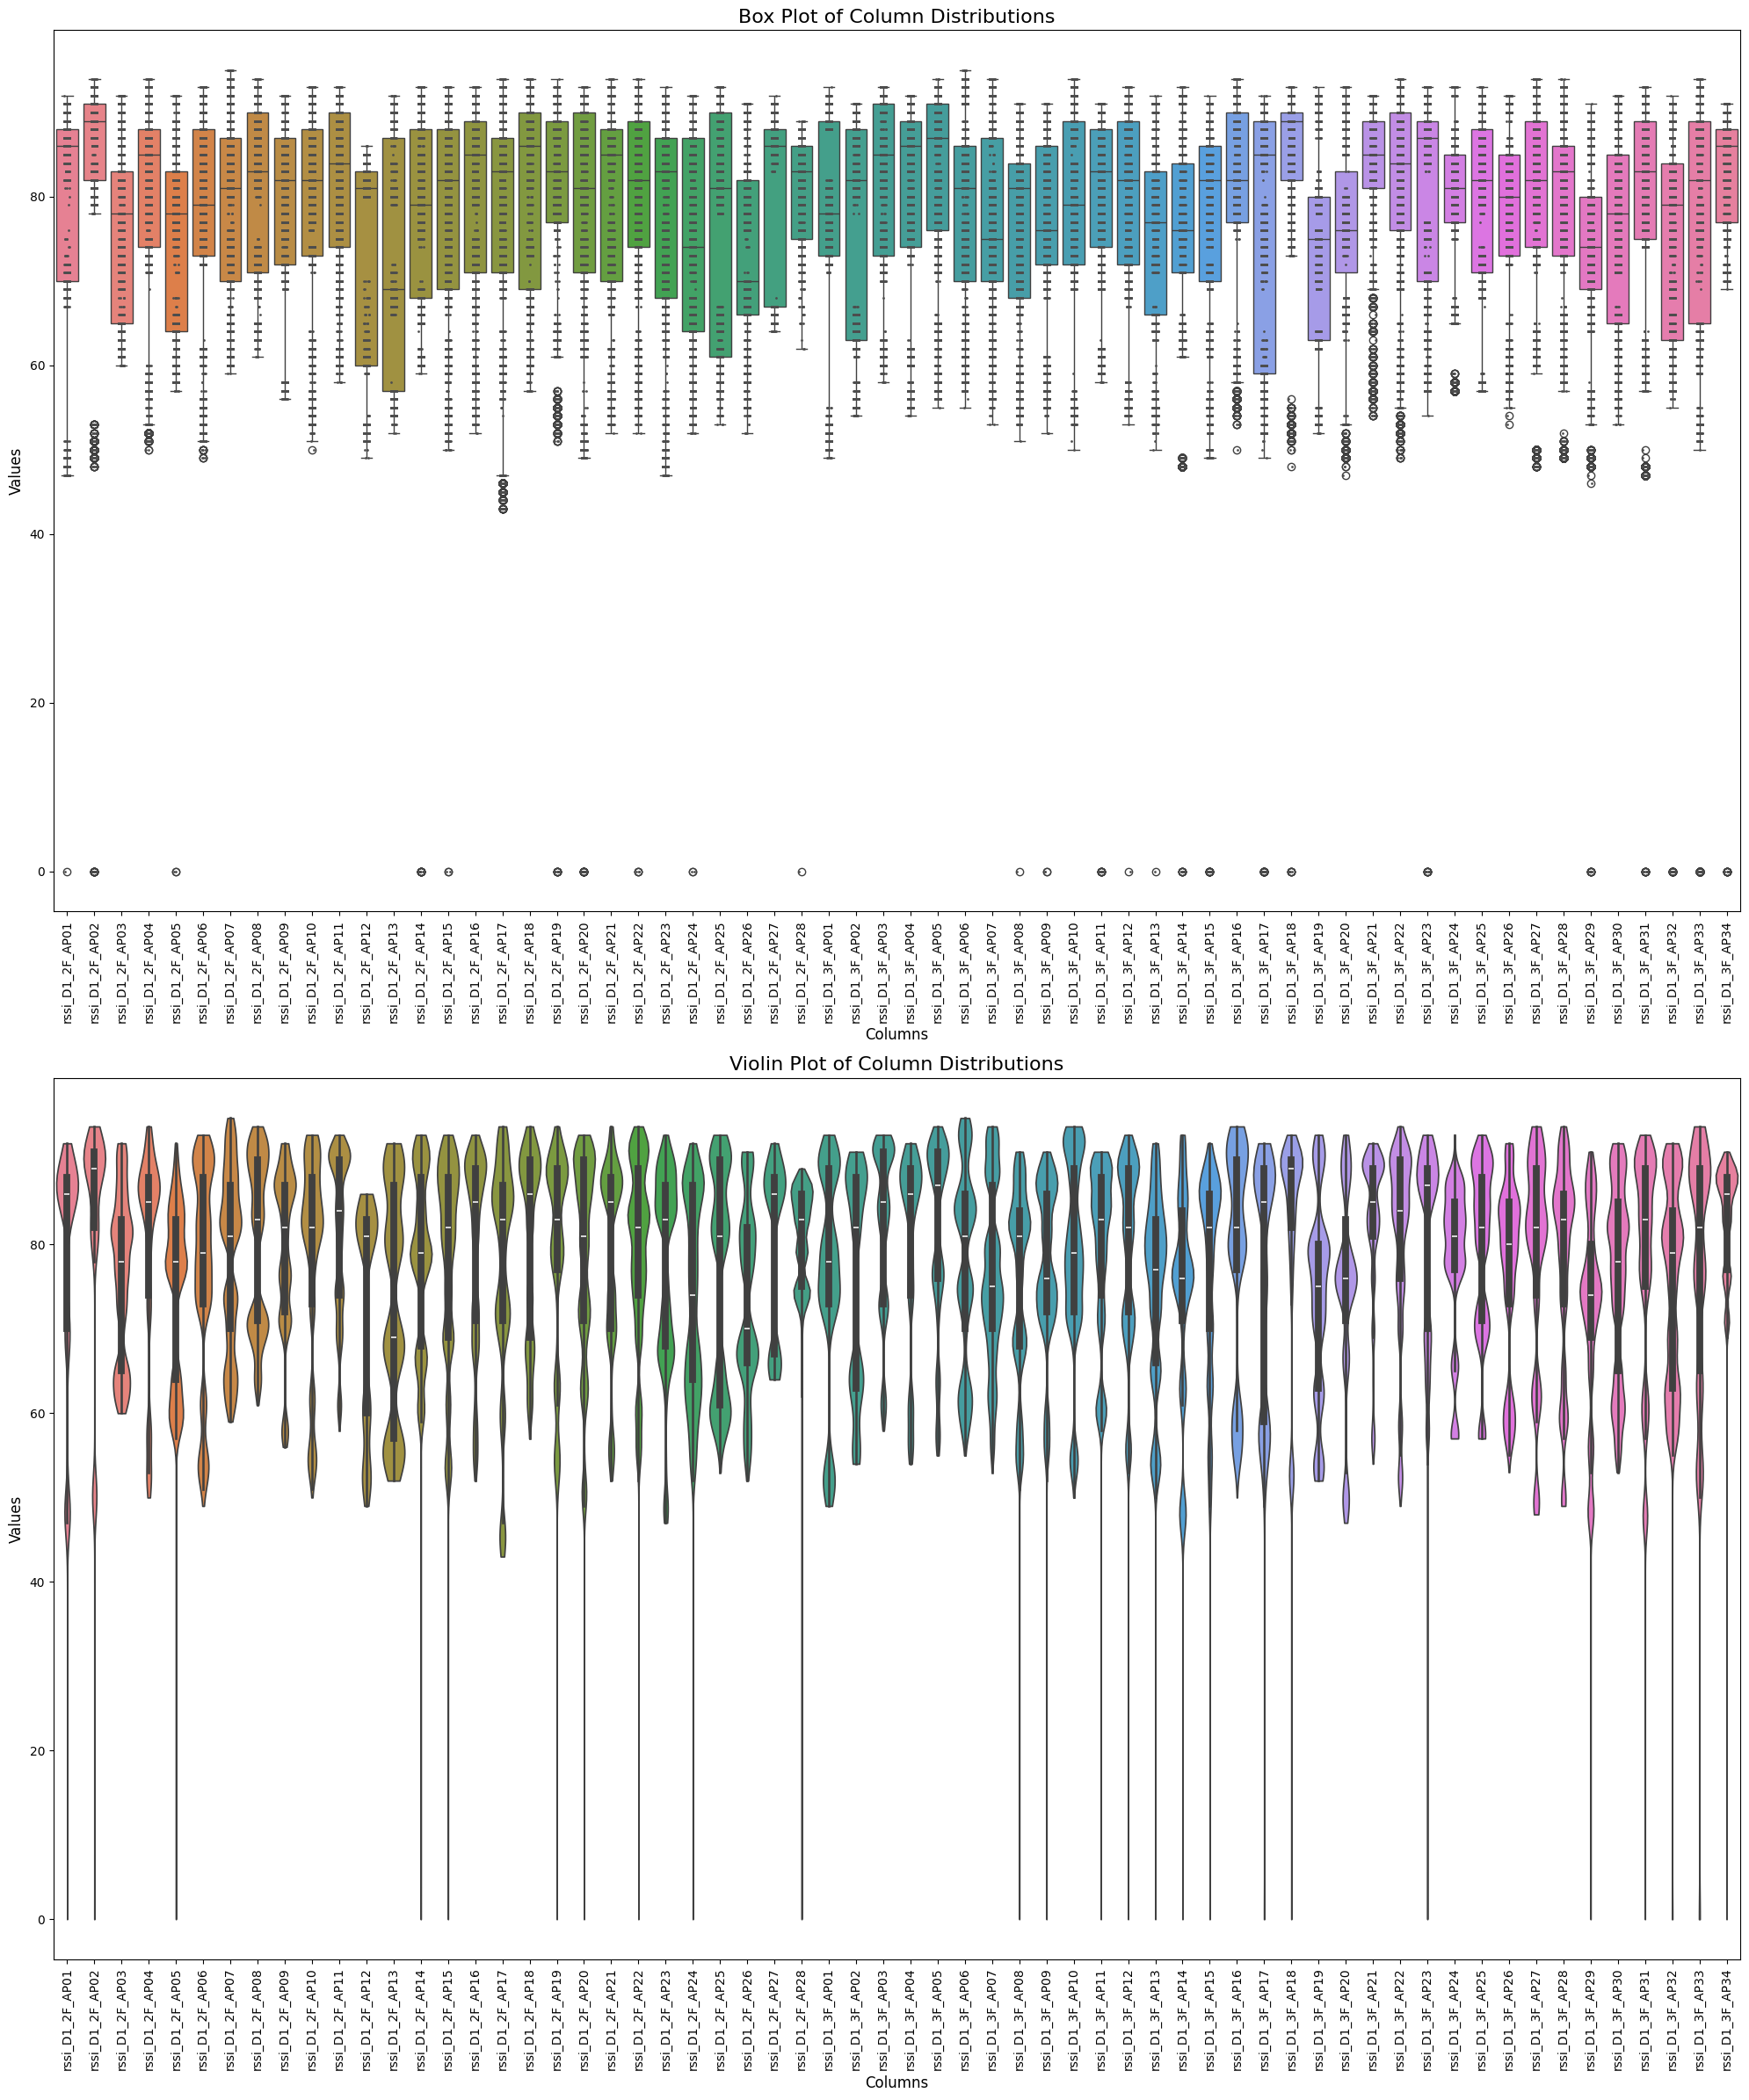

       rssi_D1_2F_AP01  rssi_D1_2F_AP02  rssi_D1_2F_AP03  rssi_D1_2F_AP04  \
count      3943.000000      5097.000000      4277.000000      6454.000000   
mean         79.050469        83.610163        76.592471        79.824915   
std          14.152096        13.363755         9.450386        12.522091   
min           0.000000         0.000000        60.000000        50.000000   
25%          70.000000        82.000000        65.000000        74.000000   
50%          86.000000        89.000000        78.000000        85.000000   
75%          88.000000        91.000000        83.000000        88.000000   
max          92.000000        94.000000        92.000000        94.000000   

       rssi_D1_2F_AP05  rssi_D1_2F_AP06  rssi_D1_2F_AP07  rssi_D1_2F_AP08  \
count      5296.000000      8245.000000      7769.000000      6907.000000   
mean         74.797583        77.207520        78.283434        80.466049   
std          10.125958        12.389923        10.254686        10.051423  

In [49]:
# Select the columns we want to plot
selected_data = data.iloc[:, 4:-4]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 24))

# Box plot
sns.boxplot(data=selected_data, ax=ax1, whis=1.5)
ax1.set_title('Box Plot of Column Distributions', fontsize=16)
ax1.set_xlabel('Columns', fontsize=12)
ax1.set_ylabel('Values', fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# Add strip plot to show individual points
sns.stripplot(data=selected_data, ax=ax1, size=2, color=".3", linewidth=0)

# Violin plot
sns.violinplot(data=selected_data, ax=ax2, cut=0)
ax2.set_title('Violin Plot of Column Distributions', fontsize=16)
ax2.set_xlabel('Columns', fontsize=12)
ax2.set_ylabel('Values', fontsize=12)
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.show()

print(selected_data.describe())

## Label Encoding

In [50]:
def encode_and_save_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Fit and transform the data
    encoded_values = le.fit_transform(data[column_name])
    
    # Replace the original column with encoded values
    data[column_name] = encoded_values
    
    # Save the encoder to a file
    with open(encoder_file_name, 'wb') as file:
        pickle.dump(le, file)
    
    print(f"Encoded {column_name} and saved encoder to {encoder_file_name}")
    
    return data

def decode_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded values back to original labels
    decoded_values = le.inverse_transform(data[column_name])
    
    # Replace the encoded column with decoded values
    data[column_name] = decoded_values
    
    print(f"Decoded {column_name} using encoder from {encoder_file_name}")
    
    return data

def decode_predictions(y_pred, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded predictions back to original labels
    decoded_predictions = le.inverse_transform(y_pred)
    
    print(f"Decoded predictions using encoder from {encoder_file_name}")
    
    return decoded_predictions

## To see the mapping
#with open('label_encoder.pkl', 'rb') as file:
#    le = pickle.load(file)
#    print("Label Mapping:")
#    for i, label in enumerate(le.classes_):
#        print(f"{label} -> {i}")

In [51]:
df = data.iloc[:, 4:-4]
df = encode_and_save_labels(df, 'ap_name')
df = df.rename(columns={'ap_name': 'label'})

Encoded ap_name and saved encoder to label_encoder.pkl


In [52]:
df

,rssi_D1_2F_AP01,rssi_D1_2F_AP02,rssi_D1_2F_AP03,rssi_D1_2F_AP04,rssi_D1_2F_AP05,rssi_D1_2F_AP06,rssi_D1_2F_AP07,rssi_D1_2F_AP08,rssi_D1_2F_AP09,rssi_D1_2F_AP10,...,rssi_D1_3F_AP26,rssi_D1_3F_AP27,rssi_D1_3F_AP28,rssi_D1_3F_AP29,rssi_D1_3F_AP30,rssi_D1_3F_AP31,rssi_D1_3F_AP32,rssi_D1_3F_AP33,rssi_D1_3F_AP34,label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,85.0,...,NaN,NaN,87.0,NaN,NaN,NaN,NaN,NaN,NaN,15
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,75.0,63.0,NaN,25
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,74.0,50.0,NaN,55.0,75.0,80.0,NaN,NaN,54
9,87.0,82.0,NaN,57.0,76.0,88.0,91.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
10,89.0,89.0,62.0,NaN,60.0,76.0,86.0,87.0,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,38
70438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
70444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,40
70449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.0,79.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,49


## Scaling using Robust Scaler

In [53]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]  

In [54]:
robust_scaled_data = RobustScaler().fit_transform(X)

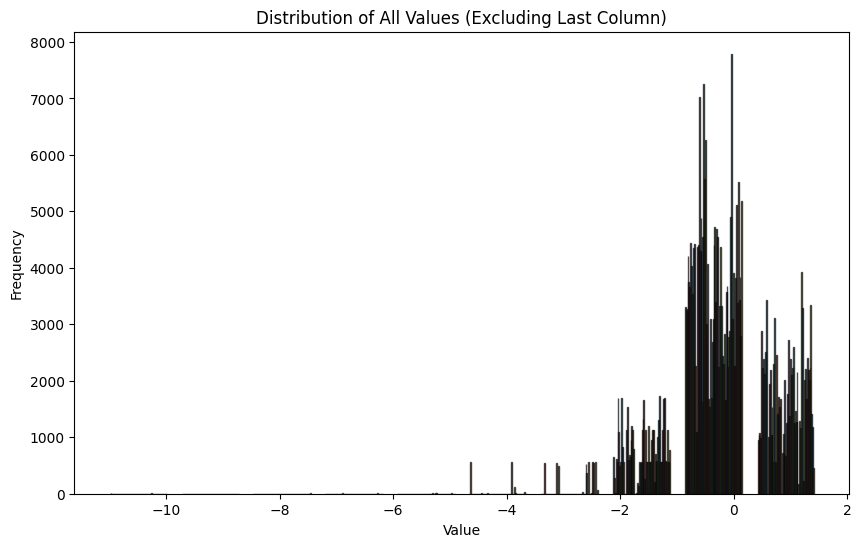

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(robust_scaled_data, edgecolor='k', alpha=0.7)
plt.title('Distribution of All Values (Excluding Last Column)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

#### Are there overlapping points in the data?

In [56]:
binned_data = df.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,label
rssi_D1_2F_AP01,rssi_D1_2F_AP02,rssi_D1_2F_AP03,rssi_D1_2F_AP04,rssi_D1_2F_AP05,rssi_D1_2F_AP06,rssi_D1_2F_AP07,rssi_D1_2F_AP08,rssi_D1_2F_AP09,rssi_D1_2F_AP10,rssi_D1_2F_AP11,rssi_D1_2F_AP12,rssi_D1_2F_AP13,rssi_D1_2F_AP14,rssi_D1_2F_AP15,rssi_D1_2F_AP16,rssi_D1_2F_AP17,rssi_D1_2F_AP18,rssi_D1_2F_AP19,rssi_D1_2F_AP20,rssi_D1_2F_AP21,rssi_D1_2F_AP22,rssi_D1_2F_AP23,rssi_D1_2F_AP24,rssi_D1_2F_AP25,rssi_D1_2F_AP26,rssi_D1_2F_AP27,rssi_D1_2F_AP28,rssi_D1_3F_AP01,rssi_D1_3F_AP02,rssi_D1_3F_AP03,rssi_D1_3F_AP04,rssi_D1_3F_AP05,rssi_D1_3F_AP06,rssi_D1_3F_AP07,rssi_D1_3F_AP08,rssi_D1_3F_AP09,rssi_D1_3F_AP10,rssi_D1_3F_AP11,rssi_D1_3F_AP12,rssi_D1_3F_AP13,rssi_D1_3F_AP14,rssi_D1_3F_AP15,rssi_D1_3F_AP16,rssi_D1_3F_AP17,rssi_D1_3F_AP18,rssi_D1_3F_AP19,rssi_D1_3F_AP20,rssi_D1_3F_AP21,rssi_D1_3F_AP22,rssi_D1_3F_AP23,rssi_D1_3F_AP24,rssi_D1_3F_AP25,rssi_D1_3F_AP26,rssi_D1_3F_AP27,rssi_D1_3F_AP28,rssi_D1_3F_AP29,rssi_D1_3F_AP30,rssi_D1_3F_AP31,rssi_D1_3F_AP32,rssi_D1_3F_AP33,rssi_D1_3F_AP34,


In [57]:
# delete overlapping data 
non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
df = df[non_overlapping_mask]
df.shape

(33840, 63)

## Model XGBClassifier With Standard Scaler

In [58]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = CustomDataset(robust_scaled_data, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(robust_scaled_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [60]:
y_train.size, y_val.size, y_test.size

(23823, 3249, 6768)

In [61]:
# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False)

# Train the model
xgb_clf.fit(X_train, y_train)

/home/sionna/Documents/GitTest2/sionna_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:33:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [62]:
# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       121
           3       1.00      1.00      1.00       122
           4       1.00      1.00      1.00       113
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        99
           7       1.00      1.00      1.00       105
           8       1.00      1.00      1.00       113
           9       1.00      1.00      1.00       118
          10       1.00      1.00      1.00        88
          11       1.00      1.00      1.00       113
          12       1.00      1.00      1.00       114
          13       1.00      1.00      1.00       104
          14       1.00      1.00      1.00       124
          15       0.99      1.00      1.00       102
          16       1.00      1.00      1.00

In [63]:
decoded_y_pred = decode_predictions(y_pred)
decoded_y_test = decode_predictions(y_test)

Decoded predictions using encoder from label_encoder.pkl
Decoded predictions using encoder from label_encoder.pkl


In [64]:
def plot_ap_positions(data, y_test, y_pred):
    unique_floors = data['ap_name'].str.extract('(\d+F)')[0].unique()
    num_floors = len(unique_floors)
    fig, axes = plt.subplots(1, num_floors, figsize=(12 * num_floors // 2, 8))

    ap_positions = dict(zip(data['ap_name'], zip(data['x'], data['y'])))

    for i, floor in enumerate(sorted(unique_floors)):
        floor_mask = [floor in ap for ap in y_test]
        floor_y_test = y_test[floor_mask]
        floor_y_pred = y_pred[floor_mask]

        test_positions = [ap_positions[ap] for ap in floor_y_test]
        pred_positions = [ap_positions[ap] for ap in floor_y_pred]

        position_accuracy = defaultdict(lambda: {'correct': 0, 'total': 0})
        for true_pos, true_ap, pred_ap in zip(test_positions, floor_y_test, floor_y_pred):
            position_accuracy[true_pos]['total'] += 1
            if true_ap == pred_ap:
                position_accuracy[true_pos]['correct'] += 1

        position_percentage = {pos: (data['correct'] / data['total']) * 100 
                               for pos, data in position_accuracy.items()}

        x_test, y_test_coords = zip(*test_positions)
        x_pred, y_pred_coords = zip(*pred_positions)

        axes[i].scatter(x_test, y_test_coords, c='green', marker='o', s=200, alpha=0.5, label='Ground Truth')
        scatter = axes[i].scatter(x_pred, y_pred_coords, 
                                  c=[position_percentage.get(pos, 0) for pos in test_positions],
                                  cmap='RdYlGn', vmin=0, vmax=100, s=50, alpha=0.7)

        correct_predictions = sum(true == pred for true, pred in zip(floor_y_test, floor_y_pred))
        total_predictions = len(floor_y_test)
        overall_accuracy = (correct_predictions / total_predictions) * 100

        axes[i].set_title(f'AP Positions on {floor}\nAccuracy: {overall_accuracy:.2f}%')
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')
        axes[i].grid(True)

    plt.tight_layout()
    cbar = fig.colorbar(scatter, ax=axes.ravel().tolist())
    cbar.set_label('Percentage of Correct Predictions')
    plt.show()

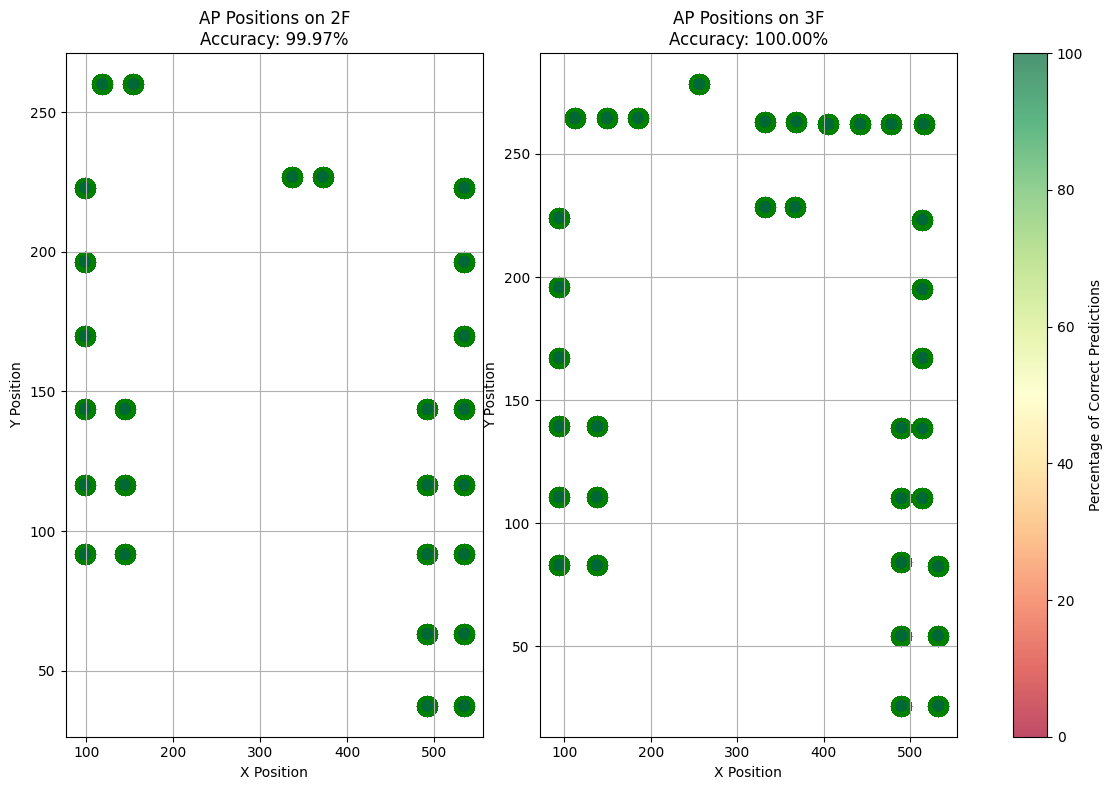

In [65]:
plot_ap_positions(data, decoded_y_test, decoded_y_pred)

## Regression Model

In [66]:
d_loc = data.iloc[:, 4:-1]
d_loc = d_loc.drop(columns=['ap_name'])

In [67]:
X = d_loc.iloc[:, :-3]
y = d_loc.iloc[:, -3:]

In [68]:
regression_data_scaled = RobustScaler().fit_transform(X)
dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(robust_scaled_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [70]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [71]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

In [72]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

/home/sionna/Documents/GitTest2/sionna_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
38 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sionna/Documents/GitTest2/sionna_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sionna/Documents/GitTest2/sionna_env/lib/python3.11/site-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sionna/Documents/Gi

,estimator,"MultiOutputRe...ee=None, ...))"
,param_grid,"{'estimator__learning_rate': [0.01, 0.1, ...], 'estimator__max_depth': [3, 4, ...], 'estimator__n_estimators': [100, 200, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [73]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'x' if i==0 else 'y' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 4
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (x):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  feature_weights: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.3
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 4
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: No

In [74]:
# Make predictions
y_pred = best_model.predict(X_test)

In [75]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"\nOverall Mean Squared Error: {mse}")

# Calculate and print MSE for each coordinate
for i, coord in enumerate(['x', 'y', 'z']):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"MSE for {coord}: {mse}")


Overall Mean Squared Error: 0.9010124206542969
MSE for x: 0.7789773029758895
MSE for y: 1.8619290636447394
MSE for z: 0.062130751390010494


In [76]:
# Feature importance
feature_importance = np.mean([estimator.feature_importances_ for estimator in best_model.estimators_], axis=0)
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print("\nTop 10 most important features:")
print(feature_importance_df.head(10))


Top 10 most important features:
            feature  importance
33  rssi_D1_3F_AP06    0.104718
5   rssi_D1_2F_AP06    0.104292
30  rssi_D1_3F_AP03    0.050683
50  rssi_D1_3F_AP23    0.045063
29  rssi_D1_3F_AP02    0.043957
32  rssi_D1_3F_AP05    0.043186
31  rssi_D1_3F_AP04    0.041769
53  rssi_D1_3F_AP26    0.041005
28  rssi_D1_3F_AP01    0.039391
34  rssi_D1_3F_AP07    0.038128


In [77]:
# Save the model
for i, estimator in enumerate(best_model.estimators_):
    estimator.save_model(f'xgboost_ap_position_model_all_{i}.json')

In [78]:
def plot_3d_ap_positions(y_true, y_pred):
    # Calculate MSE for each point
    mse = np.mean((y_true - y_pred)**2, axis=1)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot ground truth positions in blue
    ax.scatter(y_true[:, 0], y_true[:, 1], y_true[:, 2], 
               c='green', marker='o', s=100, alpha=1, label='Ground Truth')
    
    norm = Normalize(vmin=0, vmax=10)
    # Plot predicted positions with color based on MSE
    scatter = ax.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2],
                         c=mse, norm=norm, cmap='Reds_r', s=30, alpha=0.7, label='Predicted')
    
    # Add colorbar
    cbar = fig.colorbar(scatter)
    cbar.set_label('Mean Squared Error')
    
    # Calculate overall MSE
    overall_mse = mean_squared_error(y_true, y_pred)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.legend()
    plt.title(f'3D AP Positions (2F and 3F only) - Overall MSE: {overall_mse:.4f}')
    
    plt.tight_layout()
    plt.show()


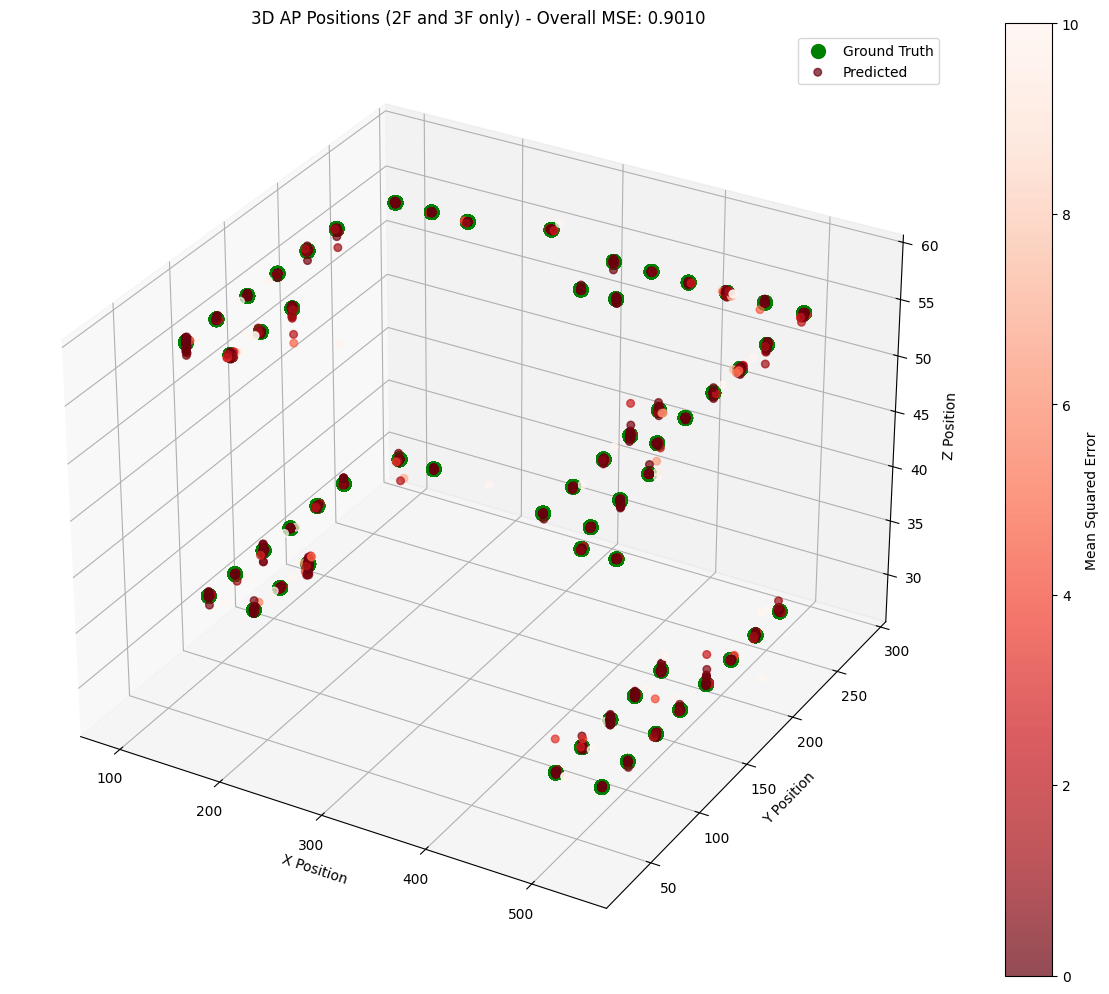

In [79]:
plot_3d_ap_positions(y_test.to_numpy(), y_pred)